In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import pandas as pd
from cuda100 import CUDABenchmark, kernel_reader

torch.__version__, torch.cuda.is_available()

('2.9.0+cu128', True)

In [28]:
%load_ext wurlitzer

import torch
from torch.utils.cpp_extension import load_inline

def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
#define BLOCKSIZE 32
'''

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [29]:
kernels = kernel_reader('kernel_naive.cu') + '\n' + \
    kernel_reader('kernel_coalescing.cu')

print(kernels)

__global__ void matrix_multiply_naive(
    const float* __restrict__ A,
    const float* __restrict__ B,
    float* __restrict__ C, 
    int M, int N, int K
) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y* blockDim.y + threadIdx.y;
    if (row < M && col < N) {
        float value = 0.0f;
        for (int i = 0; i < K; ++i) {
            value += A[row * K + i] * B[i * N + col];
        }
        C[row * N + col] = value;
    }
}
__global__ void matrix_multiply_coalescing(
    const float* __restrict__ A,
    const float* __restrict__ B,
    float* __restrict__ C, 
    int M, int N, int K
) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M && col < N) {
        float value = 0.0f;
        for (int i = 0; i < K; ++i) {
            value += A[row * K + i] * B[i * N + col];
        }
        C[row * N + col] = value;
    }
}


In [32]:
cuda_src = cuda_begin + kernels + r'''
torch::Tensor matrix_multiply_naive(torch::Tensor A, torch::Tensor B) {
    CHECK_INPUT(A); CHECK_INPUT(B);
    int m = A.size(0);
    int k = A.size(1);
    int n = B.size(1);
    auto output = torch::empty({m, n}, A.options());
    dim3 threadsPerBlock(16, 16);  // 16x16 = 256 threads per block
    dim3 blocksPerGrid((n + threadsPerBlock.x - 1) / threadsPerBlock.x,
                       (m + threadsPerBlock.y - 1) / threadsPerBlock.y);
    matrix_multiply_naive<<<blocksPerGrid, threadsPerBlock>>>(A.data_ptr<float>(), B.data_ptr<float>(), output.data_ptr<float>(), m, n, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
torch::Tensor matrix_multiply_coalescing(torch::Tensor A, torch::Tensor B) {
    CHECK_INPUT(A); CHECK_INPUT(B);
    int m = A.size(0);
    int k = A.size(1);
    int n = B.size(1);
    auto output = torch::empty({m, n}, A.options());
    dim3 gridDim(cdiv(m, 32), cdiv(n, 32));
    dim3 blockDim(32 * 32);
    matrix_multiply_coalescing<<<gridDim, blockDim>>>(A.data_ptr<float>(), B.data_ptr<float>(), output.data_ptr<float>(), m, n, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

cpp_src = """
torch::Tensor matrix_multiply_naive(torch::Tensor A, torch::Tensor B);
torch::Tensor matrix_multiply_coalescing(torch::Tensor A, torch::Tensor B);
"""

funcs = [
    'matrix_multiply_naive',
    'matrix_multiply_coalescing'
]

module = load_cuda(cuda_src, cpp_src, funcs, opt=True, verbose=True)

dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'matrix_multiply_coalescing',
 'matrix_multiply_naive']

In [33]:
A = torch.tensor([[1.0, 2.0, 3.0],
                  [4.0, 5.0, 6.0]], dtype=torch.float32, device='cuda')
B = torch.tensor([[7.0, 8.0],
                  [9.0, 10.0],
                  [11.0, 12.0]], dtype=torch.float32, device='cuda')
C1 = A@B
C1

tensor([[ 58.,  64.],
        [139., 154.]], device='cuda:0')

In [34]:
# C2 = module.matrix_multiply(A, B)
C2 = module.matrix_multiply_coalescing(A, B)
C2

tensor([[ 58.,  64.],
        [139., 154.]], device='cuda:0')

In [37]:
# Usage example:
bench = CUDABenchmark(warmup_runs=3, benchmark_runs=10)

# Define test data
M, N, K = 8192, 6144, 4096
A = torch.randn(M, K, device='cuda')
B = torch.randn(K, N, device='cuda')

# Define implementations
implementations = {
    'matrix_multiply_naive': lambda A, B: module.matrix_multiply_naive(A, B),
    'matrix_multiply_coalescing': lambda A, B: module.matrix_multiply_coalescing(A, B),
}

# Compare against PyTorch
results_df = bench.compare_implementations(
    implementations=implementations,
    test_data={'A': A, 'B': B}, 
    reference_func=lambda A, B: A @ B,
    reference_name='PyTorch',
    atol=1e-3
)

# Display results
print(results_df[['name', 'mean_ms', 'std_ms', 'speedup', 'correct']].to_string())


                         name     mean_ms    std_ms   speedup correct
0                     PyTorch   16.458804  0.086482  1.000000     NaN
1       matrix_multiply_naive  534.332494  1.262744  0.030803   False
2  matrix_multiply_coalescing   16.756709  0.270266  0.982222   False


In [38]:
torch.cuda.empty_cache()

In [39]:
# Test different tensor sizes
sizes = [100, 1000, 10000]
size_results = []

for size in sizes:
    torch.cuda.empty_cache()
    a = torch.randn((size, size), device='cuda')
    b = torch.randn((size, size), device='cuda')
    
    result = bench.compare_implementations(
        implementations=implementations,
        test_data={'A': A, 'B': B},
        reference_func=lambda A, B: A @ B,
        reference_name='PyTorch'
    )
    result['size'] = size
    size_results.append(result)

# Combine and visualize
all_results = pd.concat(size_results)

In [40]:
def calculate_bandwidth(time_ms, size_bytes):
    """Calculate memory bandwidth in GB/s"""
    return (size_bytes / (1024**3)) / (time_ms / 1000)

# Add bandwidth to results
# Update: Calculate bandwidth based on the actual matrix sizes
M, K = A.shape
_, N = B.shape
# Total bytes = size of (A + B + C), all float32 (4 bytes)
total_bytes = (M * K + K * N + M * N) * 4
results_df['bandwidth_gbs'] = calculate_bandwidth(
    results_df['mean_ms'],
    total_bytes
)

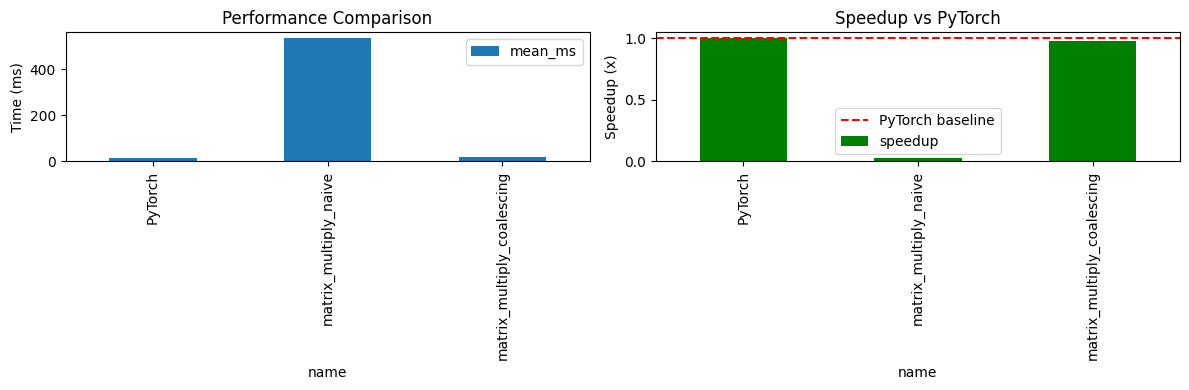

In [41]:
import matplotlib.pyplot as plt

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Time comparison
results_df.plot(x='name', y='mean_ms', kind='bar', ax=ax1, 
                yerr=results_df['std_ms'], capsize=4)
ax1.set_ylabel('Time (ms)')
ax1.set_title('Performance Comparison')

# Speedup comparison
results_df.plot(x='name', y='speedup', kind='bar', ax=ax2, color='green')
ax2.axhline(y=1.0, color='r', linestyle='--', label='PyTorch baseline')
ax2.set_ylabel('Speedup (x)')
ax2.set_title('Speedup vs PyTorch')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.empty_cache()